# Reconhecimento de Dígitos Manuscritos (uso da Normalização em lote para controle de Overfitting)

## MNIST

## Objetivo

Este Notebook constrói, treina e aplica uma Rede Neural MLP para classificar dígitos manuscritos.

O objetivo é classificar uma determinada imagem de um dígito manuscrito em uma das 10 classes que representam valores inteiros de 0 a 9.

**Este notebook utiliza a técnica de regularização Dropout para verificar o efeito da mesma no controle de Overfitting.** 

## Conjuto de dados (*Datasets*)

O MNIST ([Modified National Institute of Standards and Technology database](https://en.wikipedia.org/wiki/National_Institute_of_Standards_and_Technology)) é um grande banco de dados de dígitos manuscritos comumente utilizado para treinar vários sistemas de processamento de imagens, bem como para o treinamento e testes na área de aprendizado de máquina.

Ele foi criado pela "remistura" das amostras dos conjuntos de dados originais do NIST. Os criadores verificaram que, uma vez que o conjunto de dados de treinamento do NIST foi obtido de funcionários do American Census Bureau, enquanto o conjunto de dados de teste foi obtido de alunos do ensino médio, ele não era adequado para experimentos de aprendizado de máquina.

O MNIST é tão estudado e utilizado pela comunidade, que atua como *benchmark* para comparar o desempenho de diferentes algoritmos de reconhecimento de imagens.

* #### **Dados de treino**: 60.000 imagens 
Utilizado para criar o modelo preditivo/classificador

* #### **Dados de teste**: 10.000 imagens 
Utilizado para avaliar o modelo durante o treinamento

* #### Imagens quadradas (pequenas) em escala (níveis) de cinza de 28 × 28 pixels

*Fonte dos dados:*http://yann.lecun.com/exdb/mnist/

*Referência:* https://en.wikipedia.org/wiki/MNIST_database)

*LeNet-5:* http://yann.lecun.com/exdb/lenet/index.html

*Algumas imagens do MNIST:*

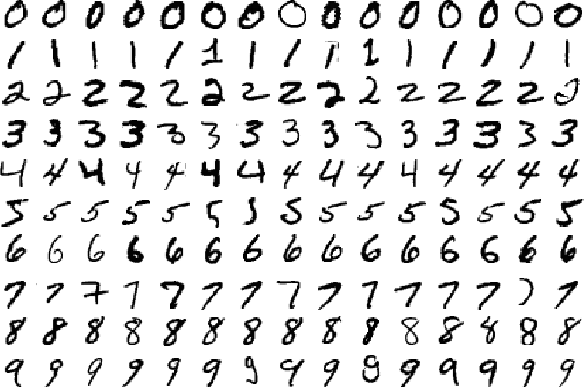

Ressalta-se que as imagens já estão centralizadas.


## Verificando a ativação da GPU

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Carregando os dados

In [2]:
from keras.datasets import mnist

(trainX, trainY), (testX, testY) = mnist.load_data()
print('Dados de treino: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Dados de teste: X=%s, y=%s' % (testX.shape, testY.shape))

11501568/11490434 [==============================] - 0s 0us/step
Dados de treino: X=(60000, 28, 28), y=(60000,)
Dados de teste: X=(10000, 28, 28), y=(10000,)


Abaixo seguem visualizações de algumas imagens do conjunto de dados de treinamento (dataset_treino).

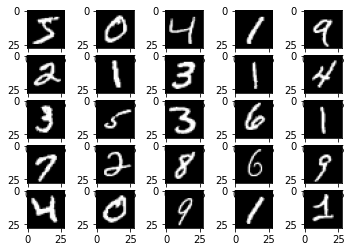

In [3]:
from matplotlib import pyplot
for i in range(25):
	# define subplot
	pyplot.subplot(5,5,i+1)
	# imprime os dados (imagens) 
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# mostra a figura
pyplot.show()

Uma vez que as imagens estão em tons de cinza podemos remodelar as matrizes de dados para ter um **único canal de cor**.

In [4]:
trainX = trainX.reshape((60000, 28, 28, 1))
testX = testX.reshape((10000, 28, 28, 1))

## Normalizando os dados

Sabemos que os valores de pixel para cada imagem no conjunto de dados são inteiros sem sinal no intervalo entre preto e branco, ou 0 e 255.

Normalizamos então os valores o intervalo [0,1]. Isso envolve primeiro a conversão do tipo de dados de inteiros sem sinal em flutuantes e, em seguida, a divisão dos valores de pixel pelo valor máximo.

In [5]:
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

## *OneHotEncoder*

Sabemos que são 10 classes (rótulos) e que as classes são representadas como inteiros únicos.

Podemos então usar uma codificação para a classe de cada amostra, transformando o inteiro em um vetor binário de 10 elementos com 1 para o índice do valor da classe e 0 valores para todas as outras classes. Podemos fazer isso com a função to_categorical().

In [7]:
from tensorflow.keras.utils import to_categorical

trainY = to_categorical(trainY)
testY = to_categorical(testY)

## Construção da Rede Neural 

Dado que o problema é uma tarefa de classificação multiclasse, teremos então uma **camada de saída com 10 nós** para prever a distribuição de probabilidade de uma imagem pertencente a cada uma das 10 classes. Isso também requer a **função de ativação softmax**.

Todas as outras camadas usarão a **função de ativação ReLU** e a estratégia de **inicialização de pesos He** (melhores recomendações para esses parâmetros).

Neste modelo estamos empregando duas camadas escondidas (intermediárias) com 300 e 100 neurônios, respectivamente, e regularização Dropout em seguida. **Você pode executar este notebook aplicando ou não o Dropout para verificar o efeito do mesmo sobre o problema de Overfitting.**

In [8]:
# Importação dos pacotes
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
# Camada de entrada que converte cada imagem 28x28 em um vetor de 784 valores
model.add(Flatten(input_shape=[28, 28]))
# 1a. camada escondida com 300 neurônios seguida de regularização Dropout
model.add(Dense(300, activation="relu"))
model.add(Dropout(0.4))
# 2a. camada escondida com 100 neurônios seguida de regularização Dropout
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.4))
# Camada de saída com 10 neurônios (10 classes!) e função de ativação softmax (multiclasse)
model.add(Dense(10, activation="softmax"))

### Sumário da arquitetura da rede neural convolucional

Execute o comando abaixo para obter um resumo da arquitetura da rede neural convolucional construída e para ver também o número de parâmetros da mesma.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
__________________________________________________

## Compilação da Rede Neural

Esta versão utiliza uma configuração conservadora para o otimizador: **gradiente estocástico com uma taxa de aprendizado de 0,01 e um momentum de 0,9**.

A função de perda (função de erro): **entropia cruzada categórica** adequada para classificação multiclasse.

E a métrica de desempenho 'accuracy' (proporção de casos corretamente previstos).

In [11]:
from keras.optimizers import SGD
# Compilando a rede
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Treinamento da Rede Neural 

In [ ]:
history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY))

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6731 - accuracy: 0.7808 - val_loss: 0.1539 - val_accuracy: 0.9546
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2133 - accuracy: 0.9377 - val_loss: 0.1166 - val_accuracy: 0.9626
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1663 - accuracy: 0.9509 - val_loss: 0.1011 - val_accuracy: 0.9678
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1441 - accuracy: 0.9569 - val_loss: 0.0861 - val_accuracy: 0.9738
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1272 - accuracy: 0.9620 - val_loss: 0.0782 - val_accuracy: 0.9758
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1123 - accuracy: 0.9671 - val_loss: 0.0743 - val_accuracy: 0.9764
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1023 - accuracy: 0.9683 - val_loss: 0.0740 - val_accuracy:

## Análise da função *loss* (erro/perda)
Vamos observar o comportamento da função *loss* para os dados de treino e de validação.

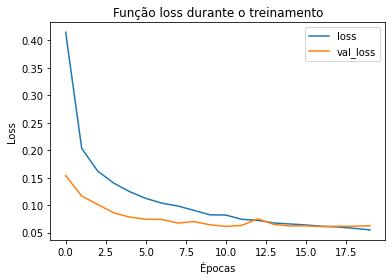

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Épocas")
plt.ylabel('Loss')
plt.title('Função loss durante o treinamento')
plt.legend(['loss', 'val_loss'])
plt.show()

## Análise da métrica de desempenho (acurácia)
Vamos observar o desempenho (acurácia) da rede para os dados de treino e de validação.

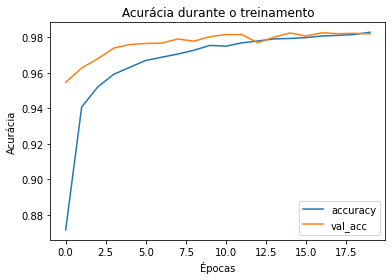

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Épocas")
plt.ylabel('Acurácia')
plt.title('Acurácia durante o treinamento')
plt.legend(['accuracy', 'val_acc'])
plt.show()